<a href="https://colab.research.google.com/github/iskra3138/colab_repo/blob/master/UofT_XAI_MVTEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Jan 30 07:45:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
cd '/gdrive/My Drive/MVTEC_LEATHER/EXP/'

/gdrive/My Drive/MVTEC_LEATHER/EXP


# CAM Visualization using uofT
출처 : https://github.com/Ruthrash/ECE1512_Assignment_XAI

### import keras model

In [4]:
import tensorflow as tf
import keras

model = keras.models.load_model('my_mvtec_model.h5')
#model.summary()

Using TensorFlow backend.
















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
import pandas as pd
import numpy as np
import os
import keras
import cv2
import matplotlib.pyplot as plt
import keras.backend as K
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import SGD
from google.colab.patches import cv2_imshow
from skimage.transform import resize

In [0]:
import os
import cv2
import numpy as np
import keras.backend as K
from keras.layers import Conv2D

def read_batch(img_dir, batch_names, batch_sz, sz):
    img_batch = np.empty((batch_sz, sz[0], sz[1], 3), dtype='uint8')
    for i in range(batch_sz):
        tmp = cv2.imread(os.path.join(img_dir, batch_names[i]))
        img_batch[i] = cv2.resize(tmp, (sz[0], sz[1]))
    return img_batch

def get_grad_cam_weights(input_model, dummy_image, should_normalize=True):
    def find_final_layer(model):
        for iter_layer, layer in reversed(list(enumerate(model.layers))):
            if type(layer) == Conv2D:
                return model.layers[iter_layer].name
        raise Exception('Could not find the final layer in provided network')
    '''
    conv_layers = []
    for i in range(len(saved_model.layers)):
      if type(saved_model.layers[i]) == Conv2D:
        conv_layers.append(saved_model.layers[i].name)
    mid_layer_idx = len(conv_layers) / 2
    mid_layer = conv_layers[int(mid_layer_idx)]
    '''
    final_layer = find_final_layer(input_model)
    conv_output = input_model.get_layer(final_layer).output
    num_classes = input_model.output_shape[1]
    num_feats = int(conv_output.shape[-1])
    weights = np.zeros((num_feats, num_classes))

    def normalize(x):
        # utility function to normalize a tensor by its L2 norm
        return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

    for iter_class in range(input_model.output_shape[1]):
        y_c = input_model.layers[-1].output[0, iter_class]
        if should_normalize:
            grad = normalize(K.gradients(y_c, conv_output)[0])
        else:
            grad = K.gradients(y_c, conv_output)[0]
        grad_func = K.function([input_model.layers[0].input, K.learning_phase()], [conv_output, grad])
        conv_val, grad_val = grad_func([dummy_image, 0])
        conv_val, grad_val = conv_val[0], grad_val[0]
        weights[:, iter_class] = np.mean(grad_val, axis=(0, 1))
    return weights, final_layer

def grad_cam(input_model, weights, images, is_pass_threshold, final_layer, conf_scores, orig_sz=[224, 224],
             should_upsample=False):
    conv_output = input_model.get_layer(final_layer).output  # activation_7
    conv_func = K.function([input_model.layers[0].input], [conv_output])
    conv_val = conv_func([images])
    conv_val = conv_val[0]
    cams = np.einsum('ijkl,lm->ijkm', conv_val, weights)
    if should_upsample:
        old_cams = cams[:]
        cams = np.zeros((old_cams.shape[0], orig_sz[0], orig_sz[1], old_cams.shape[-1]))
        for i in range(cams.shape[0]):
            for j in range(cams.shape[-1]):
                # cams[i, :, :, j] = cv2.resize(old_cams[i, :, :, j], (orig_sz[0], orig_sz[1]))
                cams[i, :, :, j] = np.maximum(cv2.resize(old_cams[i, :, :, j], (orig_sz[0], orig_sz[1])), 0)
    should_normalize = False
    if should_normalize:
        cams = cams / np.maximum(np.max(cams, axis=(1, 2, 3), keepdims=True), 1e-7)
        cams = cams * np.expand_dims(np.expand_dims(conf_scores * is_pass_threshold, axis=1), axis=2)
    else:
        cams = cams * np.expand_dims(np.expand_dims(is_pass_threshold, axis=1), axis=2)
    return cams

In [0]:
conv_layers = []
for i in range(len(saved_model.layers)):
  if type(saved_model.layers[i]) == Conv2D:
    conv_layers.append(saved_model.layers[i].name)
mid_layer_idx = len(conv_layers) / 2
mid_layer = conv_layers[int(mid_layer_idx)]

In [0]:
labels= {'NG': 0, 'OK': 1}

In [0]:
ls '/gdrive/My Drive/MVTEC_LEATHER/EXP/Test/NG'

[[1.0000000e+00 2.9864583e-10]]
[0]
Output :  NG


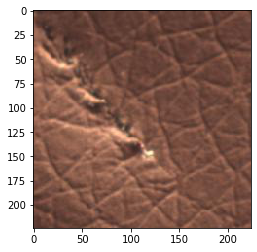

In [20]:
image_path = "/gdrive/My Drive/MVTEC_LEATHER/EXP/Test/NG/cut_017_8_5.jpg"

test_img_load = image.load_img(image_path, target_size=(224,224,3))
plt.imshow(test_img_load)

test_img = image.img_to_array(test_img_load)
test_img = np.expand_dims(test_img, axis=0)
test_img /= 255

label_map_inv = {v:k for k,v in labels.items()}

result = model.predict(test_img)
print(result)

prediction = result.argmax(axis=1)
print(prediction)

output = label_map_inv[int(prediction)]
print("Output : ",output)

In [0]:
CLASSES = ['NG','OK']

(2048, 2)
conv5_block3_3_conv


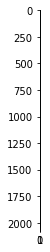

In [18]:
alpha, layer = get_grad_cam_weights(model, np.zeros((1, 224, 224, 3)))

print(alpha.shape)
plt.imshow(alpha)
print(layer)

In [0]:
Y2 = grad_cam(model, alpha, test_img, np.ones((len(test_img), len(CLASSES))), layer, result,
             orig_sz=[224,224,3], should_upsample=True)

Text(0.5, 1.0, 'NG')

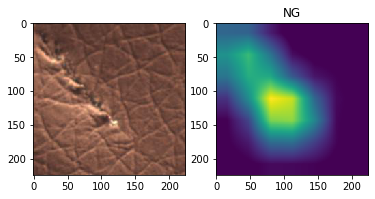

In [34]:
plt.subplot(121)
plt.imshow(test_img_load)
plt.subplot(122)
plt.imshow(Y2[0, :, :, int(prediction)])
plt.title(CLASSES[int(prediction)])

### NG Image Test

,,,,
,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

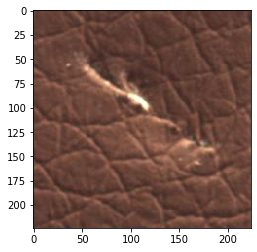

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[[1.0000000e+00 1.9822203e-11]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output :  NG


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

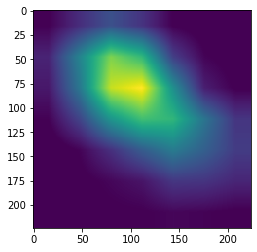

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

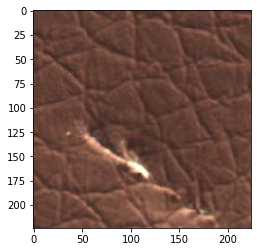

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[[1.000000e+00 8.306287e-10]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output :  NG


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

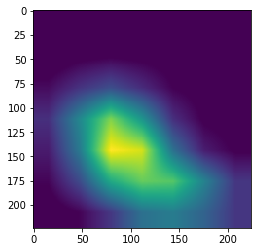

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

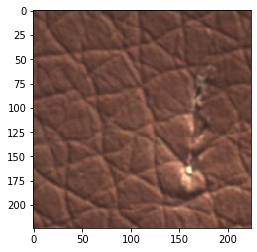

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[[1.0000000e+00 2.0639005e-08]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output :  NG


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

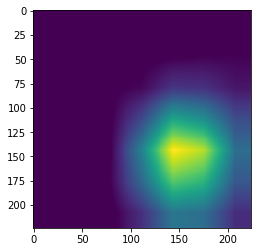

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

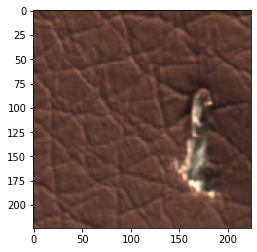

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[[1.000000e+00 8.306754e-12]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output :  NG


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

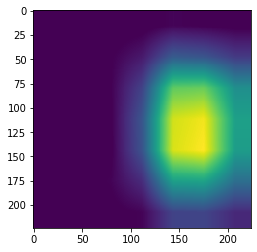

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

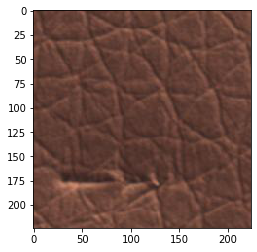

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[[9.9973053e-01 2.6943858e-04]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output :  NG


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

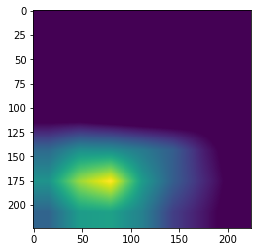

<IPython.core.display.Javascript object>

In [45]:
import glob, random
from google.colab import widgets

grid = widgets.Grid(2, 5, header_row=True, header_column=True)
for i in range(5):
  image_path = random.choice(glob.glob('/gdrive/My Drive/MVTEC_LEATHER/EXP/Test/NG/*.jpg'))
  test_img_load = image.load_img(image_path, target_size=(224,224,3))

  with grid.output_to(0, i):
    plt.imshow(test_img_load)

  test_img = image.img_to_array(test_img_load)
  test_img = np.expand_dims(test_img, axis=0)
  test_img /= 255

  label_map_inv = {v:k for k,v in labels.items()}

  result = model.predict(test_img)
  with grid.output_to(0, i):
    print(result)

  prediction = result.argmax(axis=1)
  output = label_map_inv[int(prediction)]
  with grid.output_to(0, i):
    print("Output : ",output)

  Y2 = grad_cam(model, alpha, test_img, np.ones((len(test_img), len(CLASSES))), layer, result,
             orig_sz=test_img.shape[1:3], should_upsample=True)
  
  with grid.output_to(1, i):
    plt.imshow(Y2[0, :, :, int(prediction)])

### OK Image Test

,,,,
,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

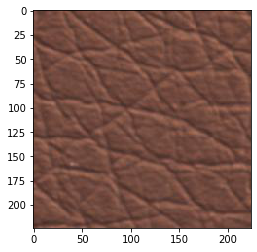

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[[7.213864e-06 9.999927e-01]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output :  OK


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

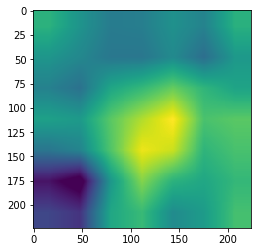

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

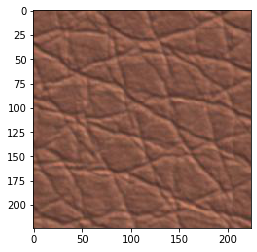

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[[1.6777411e-04 9.9983215e-01]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output :  OK


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

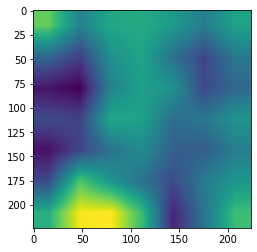

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

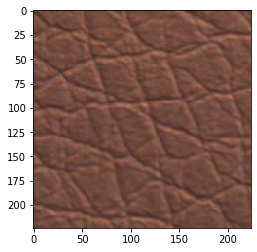

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[[1.867996e-05 9.999813e-01]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output :  OK


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

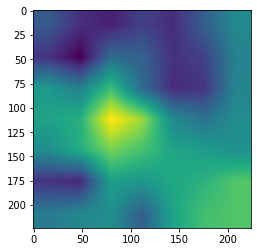

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

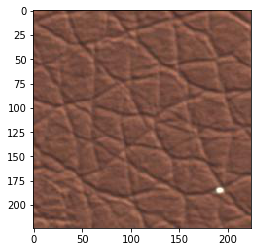

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[[0.79726994 0.20273006]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output :  NG


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

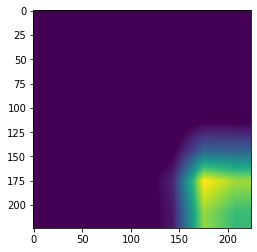

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

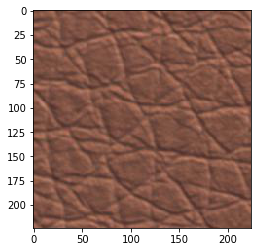

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[[1.8925364e-05 9.9998105e-01]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output :  OK


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

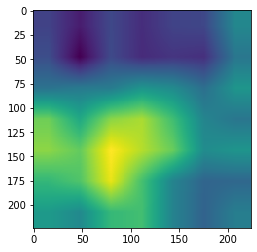

<IPython.core.display.Javascript object>

In [44]:
import glob, random
from google.colab import widgets

grid = widgets.Grid(2, 5, header_row=True, header_column=True)
for i in range(5):
  image_path = random.choice(glob.glob('/gdrive/My Drive/MVTEC_LEATHER/EXP/Test/OK/*.jpg'))
  test_img_load = image.load_img(image_path, target_size=(224,224,3))

  with grid.output_to(0, i):
    plt.imshow(test_img_load)

  test_img = image.img_to_array(test_img_load)
  test_img = np.expand_dims(test_img, axis=0)
  test_img /= 255

  label_map_inv = {v:k for k,v in labels.items()}

  result = model.predict(test_img)
  with grid.output_to(0, i):
    print(result)

  prediction = result.argmax(axis=1)
  output = label_map_inv[int(prediction)]
  with grid.output_to(0, i):
    print("Output : ",output)

  Y2 = grad_cam(model, alpha, test_img, np.ones((len(test_img), len(CLASSES))), layer, result,
             orig_sz=test_img.shape[1:3], should_upsample=True)
  
  with grid.output_to(1, i):
    plt.imshow(Y2[0, :, :, int(prediction)])